In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import sys
import torch
import torch.nn as nn
import scipy.stats
import torch.optim as optim
from torch.distributions import Categorical
import random as rand

# of episode :100, avg score : -134.6


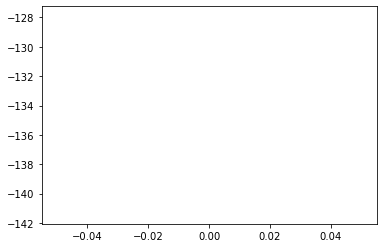

# of episode :200, avg score : -41.6


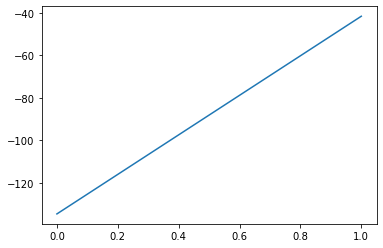

# of episode :300, avg score : -96.9


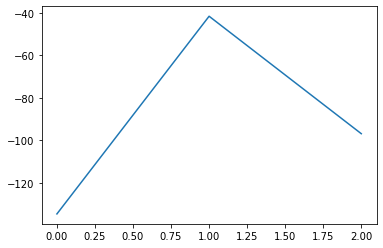

# of episode :400, avg score : -59.6


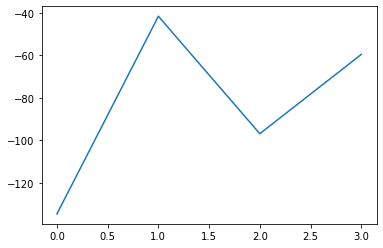

# of episode :500, avg score : -7.2


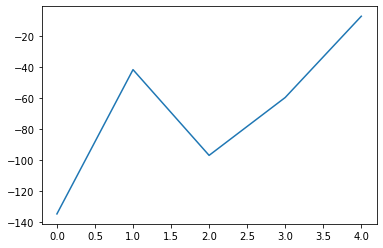

# of episode :600, avg score : 14.8


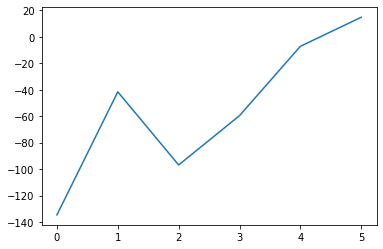

# of episode :700, avg score : -38.3


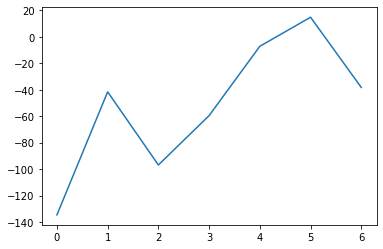

# of episode :800, avg score : -80.1


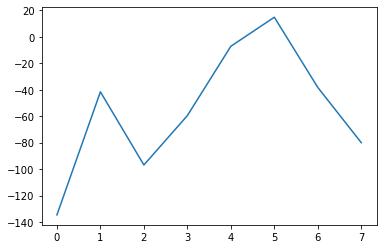

# of episode :900, avg score : -67.4


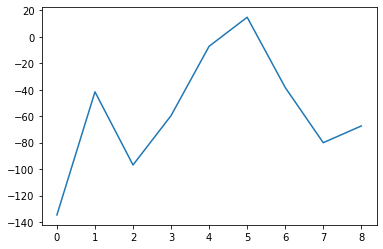

# of episode :1000, avg score : -26.0


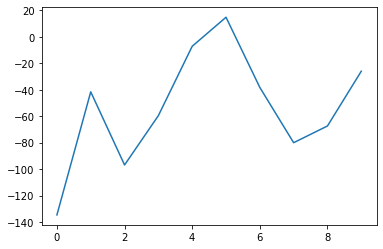

# of episode :1100, avg score : -94.0


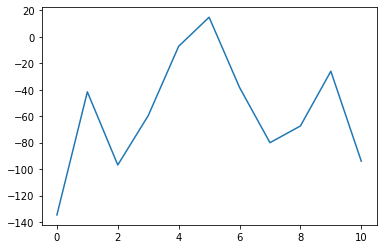

# of episode :1200, avg score : 0.2


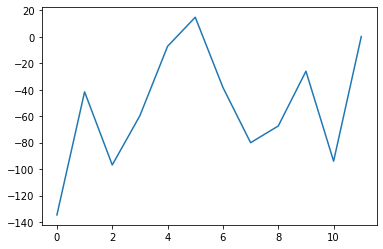

# of episode :1300, avg score : 44.9


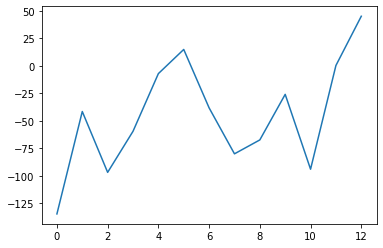

# of episode :1400, avg score : -56.5


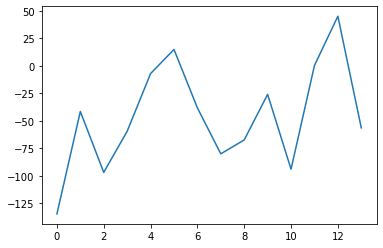

# of episode :1500, avg score : 7.1


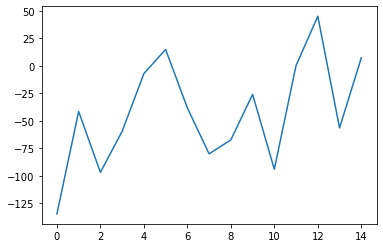

# of episode :1600, avg score : 62.4


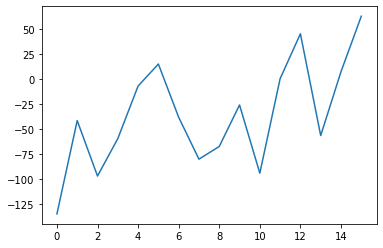

# of episode :1700, avg score : 11.2


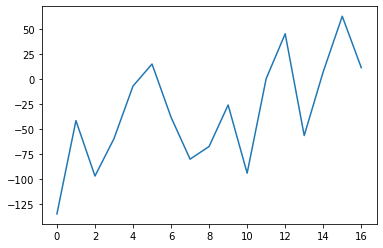

# of episode :1800, avg score : 0.6


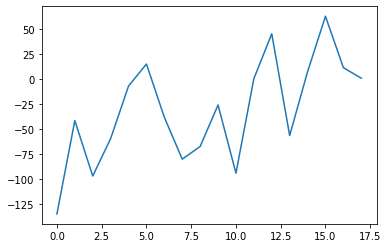

# of episode :1900, avg score : 54.8


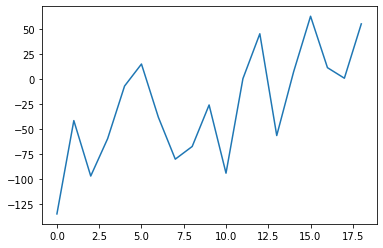

# of episode :2000, avg score : 18.5


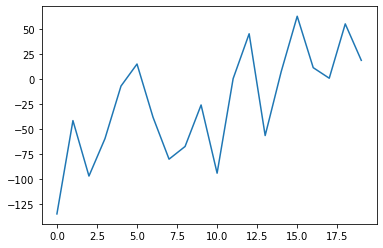

# of episode :2100, avg score : 5.9


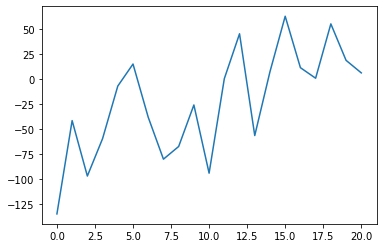

# of episode :2200, avg score : 36.2


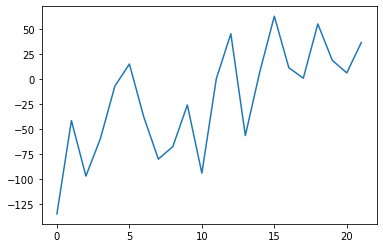

# of episode :2300, avg score : 38.3


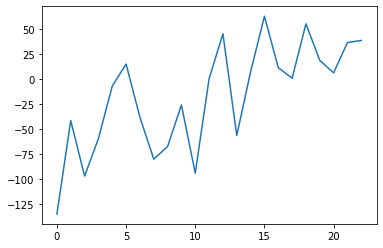

# of episode :2400, avg score : 52.9


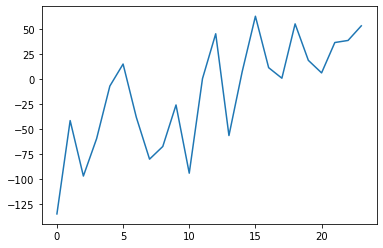

# of episode :2500, avg score : 41.0


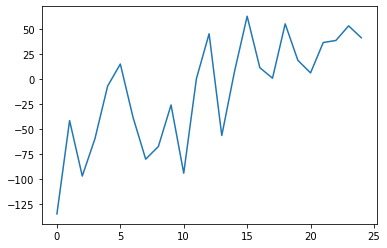

# of episode :2600, avg score : 24.6


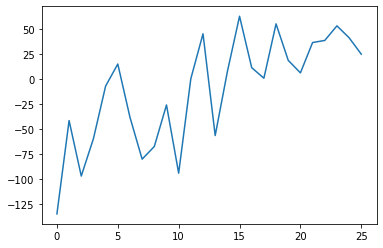

# of episode :2700, avg score : -9.9


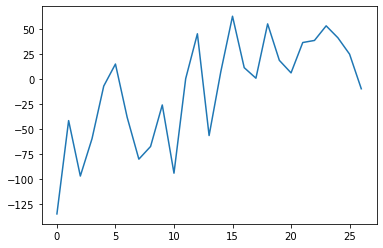

# of episode :2800, avg score : -57.1


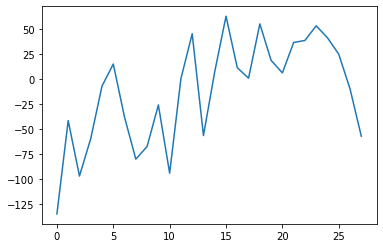

# of episode :2900, avg score : -9.2


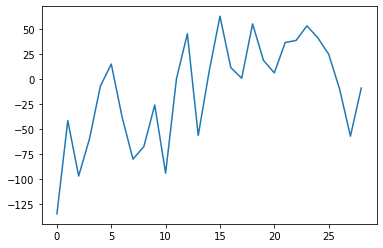

In [2]:
class Policy_Net(nn.Module):
    def __init__(self):
        super(Policy_Net, self).__init__()
        self.input_layer = nn.Linear(env.observation_space.shape[0], 128)
#         self.med_layer = nn.Linear(128, 128)
        self.action_layer = nn.Linear(128, env.action_space.n)
        self.Value_layer = nn.Linear(128, 1)

        self.ln_proba = []
        self.state_val = []
        self.reward_vec = []

    def forward(self, state):
        state = self.input_layer(state)
#         state = F.dropout(state, p=.3)
        state = F.relu(state)
#         state = self.med_layer(state)
        state = F.relu(state)
        state_value = self.Value_layer(state)

        self.prob_d = F.softmax(self.action_layer(state), dim=1)
        self.m = Categorical(self.prob_d)
        self.action = self.m.sample()

        ## m.log_prob takes the natural log of the probability associated with action
        self.ln_proba.append(self.m.log_prob(self.action))
        ## approximate the Value of a given state
        self.state_val.append(state_value)

        return self.action


device = torch.device('cpu')
Gamma = 0.99
## to reproduce graphs, leave the seed_value
seed_value = 57899

# seed_value = rand.randint(1,100000)

learning_rate = .003
torch.manual_seed(seed_value)
plot_vec = []
plot_vec2 = []
env = gym.make("LunarLander-v2")
# env = gym.make("CartPole-v1")
env.seed(seed_value)
policy = Policy_Net()
policy.to(device)
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)
max_episodes = sys.maxsize
max_episodes = 1000#1000000
See_results_after_traning = True
plotting_average_after_x_datapoints = 100
plot_vec = []
entropy_vec = []
entropy_vec2 = []
entropy_plot = []
reward_list_plot=[]
score = 0

## starts from 1 to infinity
for episodes in range(3000):
    state = env.reset()
    ep_reward = 0
    
    ## start an episode
    for t in range(1, 10000):
#         print("state: ", state)
        state = torch.from_numpy(state).float().unsqueeze(0)
        state = state.to(device)
        
        ## feed a state to the neural netowkr
        action = policy(state)
        
        ## get entropy for a a state's probability dist.
        entropy_vec.append(scipy.stats.entropy(policy.prob_d.detach().numpy()[0]))
        
        ## take an action
        action = action.item()
        state, reward, done, _ = env.step(action)
        policy.reward_vec.append(reward)
        
        ## accumulate reward  for graphs later
        ep_reward += reward
        score = score+reward
        if done:
            plot_vec.append(ep_reward)
            break

    # take the average entropy of the last game
    entropy_vec2 = sum(entropy_vec) / len(entropy_vec)

    ## after every 100 episodes, give statistics
    # if len(plot_vec) == plotting_average_after_x_datapoints:
    #     plot_vec2.append(np.average(plot_vec))
    #
    #     print("Learning rate =", learning_rate, "Seed Value=", seed_value, "Game #", episodes + 1, "Entropy =",
    #           np.round(entropy_vec2, 3), "Length of game=",
    #           len(policy.reward_vec), "Total Reward =", np.round(plot_vec2[-1], 3))
    #
    #     entropy_plot.append(entropy_vec2)
    #
    #     ## every 500 games, plot a graph of ep_reward and entropy
    #     if len(entropy_plot) % 5 == 0:
    #         fig = plt.figure()
    #         fig.suptitle('Reward')
    #         plt.plot(plot_vec2)
    #         plt.show()
    #         print("Learning rate =", learning_rate, "Seed Value=", seed_value, "Game #", episodes + 1, "Entropy =",
    #               np.round(entropy_vec2, 3), "Length of game=",
    #               len(policy.reward_vec), "Total Reward =", np.round(plot_vec2[-1], 3))
    #
    #         fig = plt.figure()
    #         plt.plot(entropy_plot)
    #
    #         fig.suptitle('Entropy')
    #         plt.show()
    #
    #         plt.close('all')
    #
    #     plot_vec = []

    ## finish episode
    R = 0
    policy_loss = []
    reward = []
    value_losses = []
    for r, value in zip(reversed(policy.reward_vec), reversed(policy.state_val)):
        ## G_t  - Q(s,a)
        R = r + (Gamma) * R - value
        reward.insert(0, R)

    reward = torch.tensor(reward)
    ## standarize the rewards
    reward = (reward - reward.mean()) / (reward.std())

    loss = 0

    for ln_prob, reward, value in zip(policy.ln_proba, reward, policy.state_val):
        ## compute the loss function, J(theta)
        action_loss = -ln_prob * reward
        loss += action_loss

    optimizer.zero_grad()
    ## back propgate
    loss.backward()
    optimizer.step()

    policy.reward_vec = []
    policy.state_val = []
    policy.ln_proba = []
    entropy_vec = []
    if episodes % 100 == 0 and episodes != 0:
        print("# of episode :{}, avg score : {:.1f}".format(episodes, score / 100))
        reward_list_plot.append(score / 100)
        plt.plot(reward_list_plot)
        plt.show()
        score = 0.0

## we are done , let's play


# torch.save(policy.state_dict(), 'model_8')




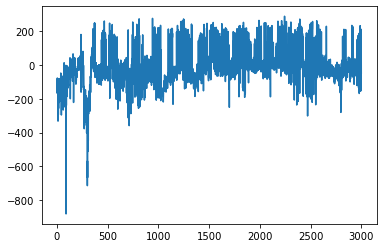

In [3]:
plt.plot(plot_vec)

In [4]:
import pandas as pd

In [5]:
pd_data = pd.DataFrame(plot_vec, columns =['Names'])
print(pd_data.head())

        Names
0 -135.117803
1 -166.873679
2  -95.489659
3 -121.555944
4  -77.735241


In [6]:
pd_data['avg'] = pd_data.Names.rolling(100).mean()


In [7]:
print(pd_data.head())

        Names  avg
0 -135.117803  NaN
1 -166.873679  NaN
2  -95.489659  NaN
3 -121.555944  NaN
4  -77.735241  NaN


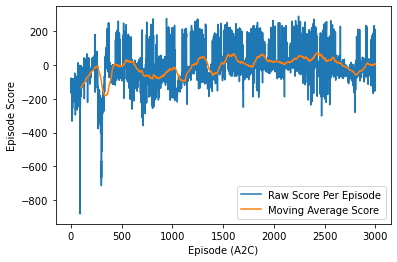

In [8]:
plt.plot(pd_data)
plt.ylabel('Episode Score')
plt.xlabel("Episode (A2C)")
plt.legend(['Raw Score Per Episode', 'Moving Average Score'])


In [9]:
##At anytime, you could stop training and run this cell to see current result
while True:
    state = env.reset()
    ep_reward = 0

    while True:

        state = torch.from_numpy(state).float().unsqueeze(0)
        state.to(device)
        probs = policy(state)

        action = probs.item()

        state, reward, done, _ = env.step(action)
        ep_reward += reward
        env.render()

        if done:
            print(ep_reward)
            ep_reward = 0
            break

-45.29386433768494
47.13619527225043
252.90532713612717
-147.81414407350258
164.59218991793313
-20.855815336378086
-189.63754090697617
-24.91086446255676
170.74070513253452
220.80754562380145
-131.26483623597767
156.26387950086902
-9.451998191507101
-144.22345823425198
97.02746875574007
-137.0643954479558
-18.292503910849064
-0.8579137812616722
3.8784492158055457
237.736703050272
-198.03541454613685
204.83350398775514
-181.19286152512393
-16.83234499970878
14.981721599264972
26.405217992036796
-138.7224636817192
-199.43683496470584
-29.387946303531237
-8.68197909823013
-3.770270991442601
-47.00836103698481
20.73240575056566
-227.2762760832322
23.66139123767178
133.62367530495786
-20.155382960289458
-32.05847165576414
-184.72318186212
26.95588048678667
40.352129792912365
204.0587582914383
155.3780181805961
-5.054414975184713
1.957326216900313
-25.088202991232205
120.33675395865559
187.5700000369758
-38.273859352346875
118.96866353294632
166.01582732216738
-54.94339021742988
201.38492093

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt

